In [1]:
%matplotlib inline

import os
import gym
import time
import copy
import random
import numpy as np

import torch
import torchvision
import torch.nn as nn

from IPython import display
from collections import deque
from skimage.color import rgb2grey
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
plt.style.use('seaborn')

In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(DeepQNetwork, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv2d(
            in_channels=num_frames,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1
            )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=2,
            padding=1
            )
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1
            )
        self.conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            stride=2,
            padding=1
            )
        self.fc1 = nn.Linear(
            in_features=25600,
            out_features=512,
            )
        self.fc2 = nn.Linear(
            in_features=512,
            out_features=num_actions
            )
        
        # Activations
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
    
    def flatten(self, x):
        x = x.view(-1)
        return x
    
    def forward(self, x):
        
        # Forward pass
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        
        return x

In [4]:
class Agent:
    def __init__(self, model, memory_depth, gamma, epsilon_i, epsilon_f, anneal_time):
        self.model = model
        self.memory_depth = memory_depth
        self.gamma = gamma
        self.e_i = epsilon_i
        self.e_f = epsilon_f
        self.anneal_time = anneal_time
        
        self.memory = deque(maxlen=memory_depth)
        self.clone()
    
    def clone(self):
        self.clone_model = copy.deepcopy(model)
    
    def remember(self, state, action, reward, terminal, next_state):
        self.memory.append([state, action, reward, terminal, next_state])
    
    def retrieve(self, batch_size):
        if batch_size > self.memories:
            batch_size = self.memories
        
        batch =  random.sample(self.memory, batch_size)
        state, action, reward, terminal, next_state = np.split(batch, axis=1)
        
        return state, action, reward, terminal, next_state
    
    @property
    def memories(self):
        return len(self.memory)
    
    def act(self, state):
        q_values = self.model(state).detach()
        action = np.argmax(q_values.numpy())
        return action
    
    def process(self, state):
        state = rgb2grey(state[35:195, :, :])
        state = state[np.newaxis, np.newaxis, :, :]
        return to_tensor(state)
    
    def exploration_rate(self, t):
        if t < self.anneal_time:
            return self.e_i - t*(self.e_i - self.e_f)/self.anneal_time
        elif t >= self.anneal_time:
            return self.e_f
    
    def update(self, batch_size):
        state, action, reward, terminal, next_state = self.retrieve(batch_size)
        
        q = self.clone_model(state).detach().numpy()
        q_target = reward + self.gamma*self.clone_model(next_state).detach().numpy()
        
        loss = mse(q, q_target)
        
        loss.backward()
        optimizer.step()

In [5]:
# Hyperparameters

batch_size = 32
update_interval = 40
clone_interval = 5
frame_skip = 4
num_frames = 4
num_actions = 4
episodes = 5
memory_depth = int(1e5)
epsilon_i = 1.0
epsilon_f = 0.1
anneal_time = 100
gamma = 0.99

In [6]:
model = DeepQNetwork(num_frames, num_actions)

In [7]:
agent = Agent(model, memory_depth, gamma, epsilon_i, epsilon_f, anneal_time)

In [8]:
cuda = True if torch.cuda.is_available() else False
to_tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [9]:
env = gym.make('Breakout-v0')

In [10]:
def q_iteration(episodes):
    
    for episode in tqdm(range(episodes)):
        
        state = env.reset()
        state = agent.process(state)
        
        done = False
        total_reward = 0
        t = 0

        while not done:
            
            env.render()
            
            while state.size()[1] < num_frames:
                action = np.random.choice(num_actions)
                
                new_frame, reward, done, info = env.step(action)
                new_frame = agent.process(new_frame)
                
                state = torch.cat([state, new_frame], 1)
                
            if np.random.uniform() < agent.exploration_rate(t):
                action = np.random.choice(num_actions)

            else:
                action = agent.act(state)
                
            new_frame, reward, done, info = env.step(action)
            new_frame = agent.process(new_frame)
            
            new_state = torch.cat([state, new_frame], 1)
            new_state = new_state[:, 1:, :, :]

            agent.remember(state.detach().numpy(), action, reward, done, new_state.detach().numpy())

            state = new_state
            total_reward += reward
            t += 1
            
#             if t % update_interval == 0:
#                 agent.update(batch_size)

        plt.scatter(episode, total_reward)
        plt.xlim(0, episodes)
        plt.xlabel("Episode")
        plt.ylabel("Return")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        if episode % clone_interval == 0:
            agent.clone()

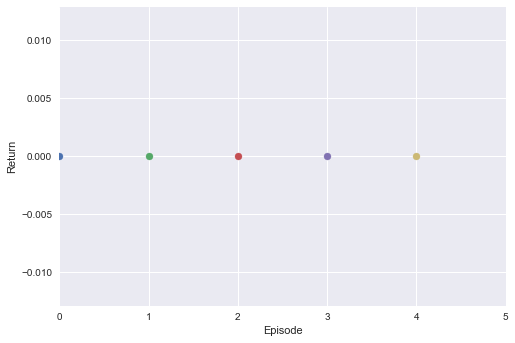

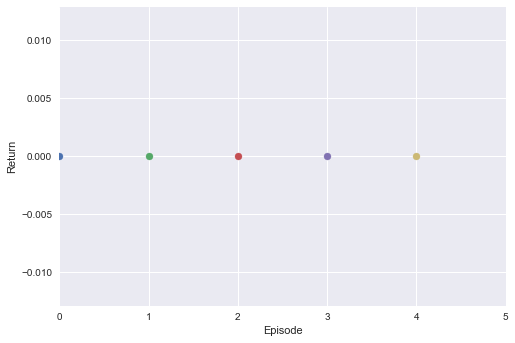

In [11]:
q_iteration(5)

In [15]:
x = np.array(agent.update(32))

In [16]:
x.shape

(32, 5)

In [18]:
x[0][0].shape

(1, 4, 160, 160)